# $R_{1\rho}$ Relaxation

In [1]:
#!git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
%matplotlib notebook

## Build the system
In this example, we first look at $R_{1\rho}$ relaxation due to reorienation of a dipole coupling and CSA (typical for $^{15}$N)

In [3]:
ex0=RS.ExpSys(v0H=850,Nucs=['15N','1H'],vr=45000)
ex1=ex0.copy()
delta=RS.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex0.set_inter('CSA',i=0,delta=150,euler=[0,15*np.pi/180,0])
ex1.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,30*np.pi/180,0])
ex1.set_inter('CSA',i=0,delta=150,euler=[[0,15*np.pi/180,0],[0,30*np.pi/180,0]])

## Add the exchange process (symmetric exchange)
First, export this sytem into Liouville space, allowing us to introduce an exchange process. Then we'll define a correlation time and population 1 and population 2. Here we start assuming the populations, $p_1$ and $p_2$ are equal.

In [10]:
L=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

tc=1e-6     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
    np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
L.kex=kex

## Monitor the decay under a spin-lock
We have to define a sequence to include RF fields. In this case, we'll just take default behavior which is to apply a continuous field for one rotor cycle.

In [11]:
t0=time()
seq=L.Sequence()
seq.add_channel('15N',v1=25000)
U=seq.U()**50    #Take 50 rotor periods at a time (50/45000=1.11 ms)

rho=RS.Rho(rho0='15Nx',detect='15Nx')
_=rho.DetProp(U,n=200)
print(time()-t0)

2.8687329292297363


Plot the results for a simple $R_{1\rho}$ experiment

<IPython.core.display.Javascript object>


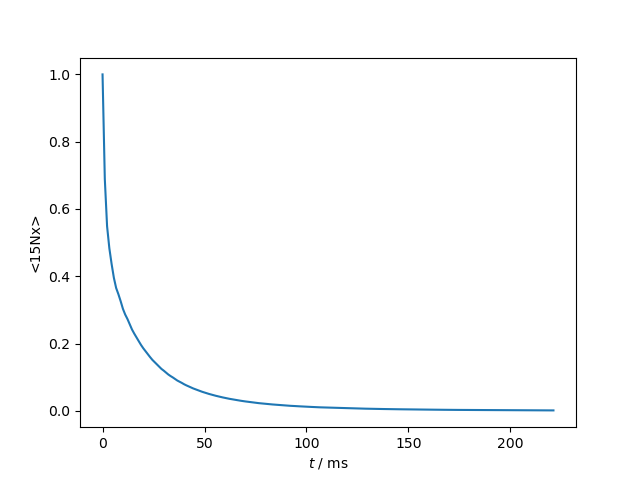

<AxesSubplot:xlabel='$t$ / ms', ylabel='<15Nx>'>

In [12]:
rho.plot()

## Observe behavior as a function of spin-lock strength
We start out with a relatively fast motion, with symmetric exchange

<IPython.core.display.Javascript object>


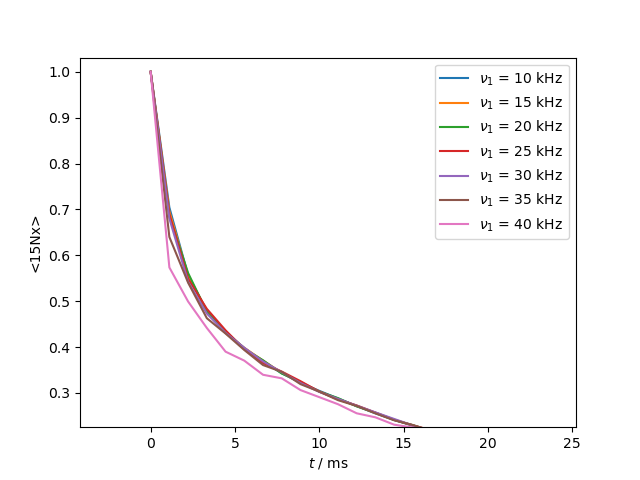

379.8018245298773
377.45132740730736
373.52953008681465
366.88922711765224
354.5947652283289
328.1134083323645
255.85879243489555
19.243454217910767


In [22]:
tc=1e-6     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
    np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
L.kex=kex

t0=time()
v10=np.linspace(10000,40000,7)  #Every 5 kHz
ax=plt.subplots()[1]
for v1 in v10:
    seq.add_channel('15N',v1=v1)
    U=seq.U()
    rho.clear()
    print(rho.extract_decay_rates(U,pwdavg=True))
    U=U**50
    rho.DetProp(U,n=200)
    rho.plot(ax=ax)
ax.legend([r'$\nu_1$'+f' = {v1/1e3:.0f} kHz' for v1 in v10])
print(time()-t0)

## Monitor behavior for slow motion
Now, we replace the exchange rate to see the response to changing $\nu_1$ for slow motion

<IPython.core.display.Javascript object>


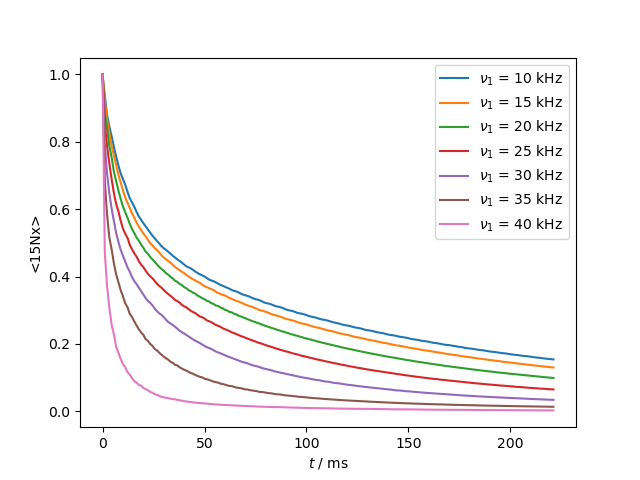

47.16825604916531
55.69707679989738
70.93369365334925
98.68287122458807
153.3040085636627
275.4079389159357
602.0076583942293
17.73501491546631


In [21]:
tc=1e-4     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
    np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
L.kex=kex

t0=time()
v10=np.linspace(10000,40000,7)  #Every 5 kHz
ax=plt.subplots()[1]
for v1 in v10:
    seq.add_channel('15N',v1=v1)
    U=seq.U()
    rho.clear()
    print(rho.extract_decay_rates(U,pwdavg=True))
    U=U**50
    rho.DetProp(U,n=200)
    rho.plot(ax=ax)
ax.legend([r'$\nu_1$'+f' = {v1/1e3:.0f} kHz' for v1 in v10])
print(time()-t0)

We see a relaxation-dispersion effect for the slow motion

## Find $R_{1\rho}$ profiles for various correlation times
Here, we sweep both $\nu_1$ and $\tau_c$. We use a function that extracts the mean relaxation rate constants from rho directly, rather than fitting the decay curves.

In [23]:
t0=time()
tc0=np.logspace(-7,-3,9)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

v10=np.linspace(10000,35000,11)  #Every 2.5 kHz
R1p=np.zeros([tc0.size,v10.size])
for k,tc in enumerate(tc0):
    kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
        np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
    L.kex=kex
    
    for m,v1 in enumerate(v10):
        rho.clear()
        seq.add_channel('15N',v1=v1)
        U=seq.U()
        R1p[k,m]=rho.extract_decay_rates(U,pwdavg=True)
        #Decay rate is approximately the loss after one point divided by the time elapsed

print(time()-t0)

272.1926951408386


Plot the results

<IPython.core.display.Javascript object>


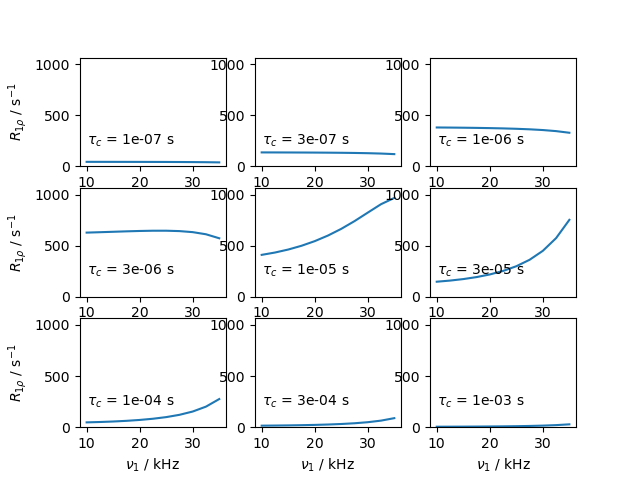

In [24]:
fig,ax=plt.subplots(3,3)
ax=ax.reshape(ax.size)

for R1p0,tc,a in zip(R1p,tc0,ax):
    a.plot(v10/1e3,R1p0)
    if a.get_subplotspec().is_last_row():
        a.set_xlabel(r'$\nu_1$ / kHz')
    if a.get_subplotspec().is_first_col():
        a.set_ylabel(r'$R_{1\rho}$ / s$^{-1}$')
    a.set_ylim([0,R1p.max()*1.1])
    a.text(10,a.get_ylim()[1]*.2,r'$\tau_c$'+f' = {tc:.0e} s')
    

In [23]:
R1p[2]

array([15.53157308, 17.15249944, 19.41182415, 22.04003173, 24.06722865,
       23.28622296, 16.75743813])